# Imports

In [44]:
import torch
import random
import numpy as np
import tensorflow as tf
import os
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D
from tensorflow.keras.utils import to_categorical

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Read dataset

In [27]:
dataset_path = 'Dataset/images'

In [28]:
def load_images(path):
  images = []
  for image in os.listdir(path):
      img_path = os.path.join(path, image)

      img = Image.open(img_path)

      images.append(img)

  return images

In [29]:
images= load_images(dataset_path)

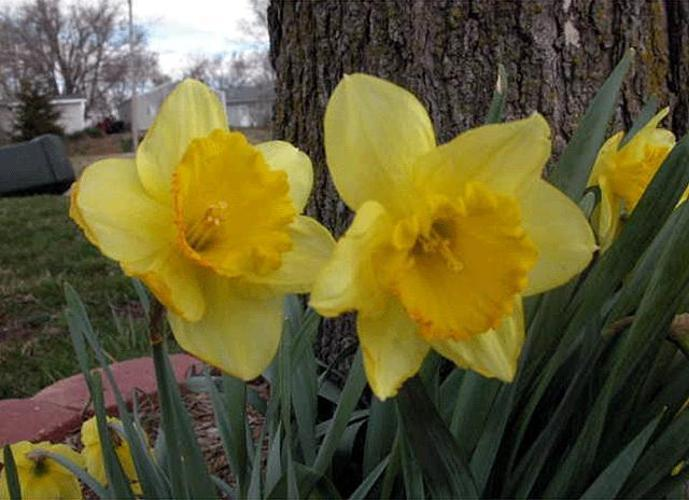

In [30]:
images[0]

In [31]:
def fix_images(images):
  array_img = []
  for img in images:
    new_size = (150, 150)

    resized_img = img.resize(new_size)
    rgb_img = resized_img.convert("RGB")
    array_img.append(np.array(rgb_img))

  return array_img

In [32]:
fixed_images = fix_images(images)

In [33]:
fixed_images[0].shape

(150, 150, 3)

In [34]:
labels = []
for i in range(17):
    labels.extend([i] * 80)

# Training

In [35]:
train_size = int(0.8 * len(fixed_images))
val_size = int(0.1 * len(fixed_images))
test_size = len(fixed_images) - train_size - val_size

# Split the lists
train_images, val_images, test_images = fixed_images[:train_size], fixed_images[train_size:train_size+val_size], fixed_images[train_size+val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]


In [36]:
len(train_images), len(train_labels), len(test_images), len(test_labels)

(1088, 1088, 136, 136)

In [37]:
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)
train_images = train_images.reshape(-1, 150, 150, 3)
val_images = val_images.reshape(-1, 150, 150, 3)
test_images = test_images.reshape(-1, 150, 150, 3)

In [38]:
base_model = keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 108s 1us/step


In [39]:
for layer in base_model.layers:
    layer.trainable = False

In [41]:
model = Sequential()

# Feature Extraction Stage
model.add(base_model)

# Classification Stage
# Construct the head of the model that will be placed on top of the base model
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=17, activation='softmax'))

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 5, 5, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,048,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,380,529 (85.37 MB)

 Trainable params: 2,049,169 (7.82 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [45]:
train_labels = to_categorical(train_labels, num_classes=17)
val_labels = to_categorical(val_labels, num_classes=17)
test_labels = to_categorical(test_labels, num_classes=17)

In [46]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((1088, 150, 150, 3), (1088, 17), (136, 150, 150, 3), (136, 17))

In [47]:
train_images = keras.applications.efficientnet_v2.preprocess_input(train_images)
val_images = keras.applications.efficientnet_v2.preprocess_input(val_images)
test_images = keras.applications.efficientnet_v2.preprocess_input(test_images)